In [1]:
from numpy.random import seed
seed(1)
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import itertools
import tensorflow
import tensorflow.keras
from tensorflow.keras.applications import ResNet152, Xception,VGG16,EfficientNetB4
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
np.random.seed(123)
print("done")

done


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
skin_df = pd.read_csv('content/HAM10000_metadata.csv')
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
skin_df.shape

(10015, 7)

In [5]:
lesion_type_dict = {'akiec': 'Actinic keratoses',
                    'bcc': 'Basal cell carcinoma',
                    'bkl': 'Benign keratosis-like lesions ',
                    'df': 'Dermatofibroma',
                    'nv': 'Melanocytic nevi',
                    'mel': 'Melanoma',
                    'vasc': 'Vascular lesions'}

base_skin_dir = os.path.join('content')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir,'*','*.jpg'))}

skin1=[]
skin2=[]
for x in skin_df['image_id']:
  if x in imageid_path_dict:
    skin1.append(imageid_path_dict.get(x))

skin_1 = pd.DataFrame(skin1)
print (len(skin_1))
skin_df['path'] = skin_1

for x in skin_df['dx']:
  if x in lesion_type_dict:
    skin2.append(lesion_type_dict.get(x))

skin_2 = pd.DataFrame(skin2)
skin_df['cell_type']=skin_2

skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.groupby(['dx']).count()

print("*************************************************************************")
print(skin_df['path'])
print("*************************************************************************")
print(skin_df['cell_type'])
print("*************************************************************************")
print(skin_df['cell_type_idx'])


10015
*************************************************************************
0        content\HAM10000_images_part_1\ISIC_0027419.jpg
1        content\HAM10000_images_part_1\ISIC_0025030.jpg
2        content\HAM10000_images_part_1\ISIC_0026769.jpg
3        content\HAM10000_images_part_1\ISIC_0025661.jpg
4        content\HAM10000_images_part_2\ISIC_0031633.jpg
                              ...                       
10010    content\HAM10000_images_part_2\ISIC_0033084.jpg
10011    content\HAM10000_images_part_2\ISIC_0033550.jpg
10012    content\HAM10000_images_part_2\ISIC_0033536.jpg
10013    content\HAM10000_images_part_2\ISIC_0032854.jpg
10014    content\HAM10000_images_part_2\ISIC_0032258.jpg
Name: path, Length: 10015, dtype: object
*************************************************************************
0        Benign keratosis-like lesions 
1        Benign keratosis-like lesions 
2        Benign keratosis-like lesions 
3        Benign keratosis-like lesions 
4        Benign ke

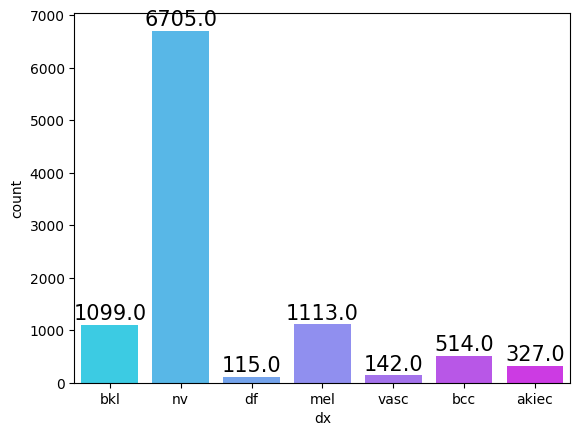

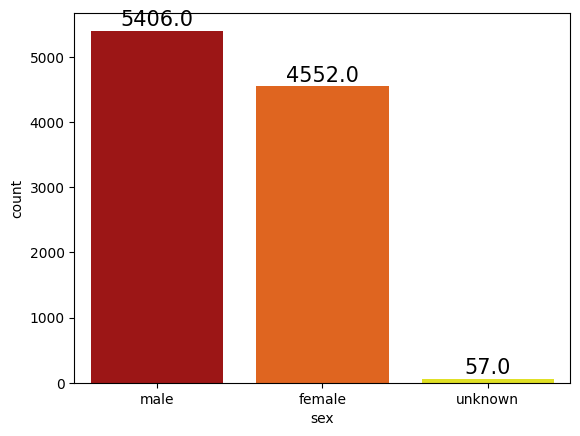

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
ax=sns.countplot(x="dx", data=skin_df,palette = "cool")
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.show()
ax=sns.countplot(x="sex", data=skin_df,palette = "hot")
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

In [7]:
from skimage.filters import unsharp_mask
skin_df['image'] = skin_df['path'].map(lambda x: 
                                       unsharp_mask(cv2.medianBlur(np.asarray((Image.open(x).resize((120,120)))),5)))
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']
print('done')

done


In [8]:
target.head()

0    2
1    2
2    2
3    2
4    2
Name: cell_type_idx, dtype: int8

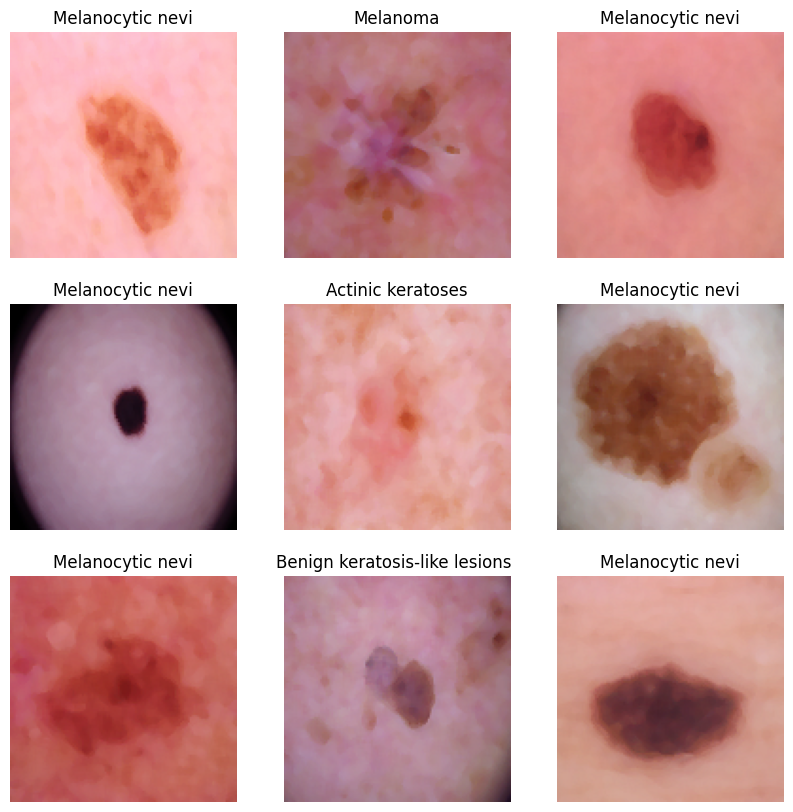

In [9]:
fig=plt.figure(figsize=(10,10))
for i in range (1,10):
  img=np.random.randint(0,10014)
  fig.add_subplot(3,3,i)
  plt.imshow(skin_df['image'][img])
  plt.title(skin_df['cell_type'][img])
  plt.axis('off') 
plt.show()

In [10]:
from tensorflow.keras.utils import to_categorical
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.2,random_state=666)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
print(x_test_o)

        lesion_id      image_id     dx    dx_type   age     sex   
2185  HAM_0004164  ISIC_0031203    mel      histo  80.0    male  \
7227  HAM_0002434  ISIC_0033253     nv      histo  40.0  female   
9713  HAM_0001621  ISIC_0030297  akiec      histo  70.0  female   
4027  HAM_0006831  ISIC_0030545     nv  follow_up  70.0  female   
7234  HAM_0000294  ISIC_0033461     nv      histo  40.0    male   
...           ...           ...    ...        ...   ...     ...   
2918  HAM_0007139  ISIC_0029342    bcc      histo  65.0  female   
960   HAM_0002792  ISIC_0033169    bkl  consensus  80.0  female   
5803  HAM_0000939  ISIC_0028620     nv  follow_up  35.0  female   
1429  HAM_0001729  ISIC_0024537    mel      histo  85.0    male   
585   HAM_0005199  ISIC_0024982    bkl      histo  55.0    male   

         localization                                             path   
2185  lower extremity  content\HAM10000_images_part_2\ISIC_0031203.jpg  \
7227             back  content\HAM10000_images_

In [11]:
x_train

array([[[[-0.8079619 , -1.12373955, -0.84251492],
         [-0.80942797, -1.12635464, -0.84578742],
         [-0.81770184, -1.134972  , -0.85666207],
         ...,
         [-0.42024095, -0.63427683, -0.64573041],
         [-0.44175036, -0.6963414 , -0.7091188 ],
         [-0.47080967, -0.6822373 , -0.73623975]],

        [[-0.81449962, -1.16050923, -0.87925835],
         [-0.81661594, -1.16602406, -0.88506884],
         [-0.82738916, -1.13789412, -0.85772385],
         ...,
         [-0.42661155, -0.59892338, -0.65625057],
         [-0.44718055, -0.65886454, -0.71784517],
         [-0.4760589 , -0.68576718, -0.7013376 ]],

        [[-0.78714063, -1.15781117, -0.87668981],
         [-0.79130407, -1.16736709, -0.88647216],
         [-0.8061984 , -1.14618368, -0.86534356],
         ...,
         [-0.39384543, -0.6079453 , -0.63246154],
         [-0.41368288, -0.66565932, -0.64582604],
         [-0.44260097, -0.69217508, -0.71259619]],

        ...,

        [[-0.43447035, -0.72220053, -0

In [12]:
x_train = x_train.reshape(x_train.shape[0], *(120, 120, 3))
x_test = x_test.reshape(x_test.shape[0], *(120, 120, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(120, 120, 3))

In [13]:
import tensorflow as tf
input_shape = (120, 120,3)
num_classes = 7
optimizer = Adam(learning_rate=1e-3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_learning_rate=1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', patience=1, verbose=1,filepath='./model.h5',save_best_only=True,mode='min')

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 average_pooling2d (AverageP  (None, 60, 60, 64)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 60, 60, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        36928     
                                                        

In [16]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train,y_train, batch_size=64),
                              epochs = 50, validation_data = (x_validate,y_validate),
                              verbose = 1,
                           callbacks=[learning_rate_reduction,mcp])

Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 1.1315 - accuracy: 0.6569
Epoch 1: val_loss improved from inf to 0.99851, saving model to .\model.h5
113/113 [==============================] - 27s 177ms/step - loss: 1.1315 - accuracy: 0.6569 - val_loss: 0.9985 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.9314 - accuracy: 0.6673
Epoch 2: val_loss improved from 0.99851 to 0.90443, saving model to .\model.h5
113/113 [==============================] - 19s 172ms/step - loss: 0.9314 - accuracy: 0.6673 - val_loss: 0.9044 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - ETA: 0s - loss: 0.8737 - accuracy: 0.6827
Epoch 3: val_loss improved from 0.90443 to 0.88109, saving model to .\model.h5
113/113 [==============================] - 20s 172ms/step - loss: 0.8737 - accuracy: 0.6827 - val_loss: 0.8811 - val_accuracy: 0.6883 - lr: 0.0010
Epoch 4/50
113/113 [==================

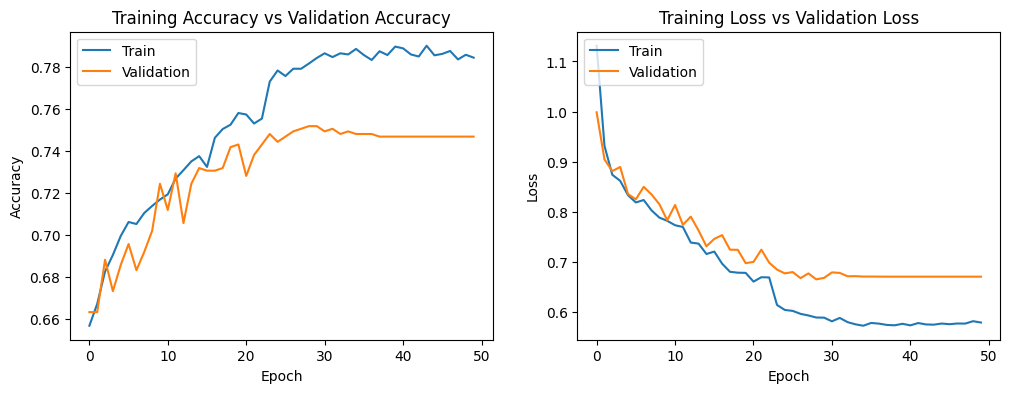

In [17]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [18]:
model=0
from keras.models import load_model
model=load_model('./model.h5')
print('loaded model.....')

loaded model.....


In [19]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
predictions = model.predict(x_test)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)
print("CNN Training: accuracy = %f" % (accuracy_t))
print("CNN Validation: accuracy = %f" % (accuracy_v))
print("CNN Test: accuracy = %f" % (accuracy))

63/63 [==============================] - 1s 11ms/step
CNN Training: accuracy = 0.794868
CNN Validation: accuracy = 0.751870
CNN Test: accuracy = 0.766850


[4 4 2 ... 4 5 2]


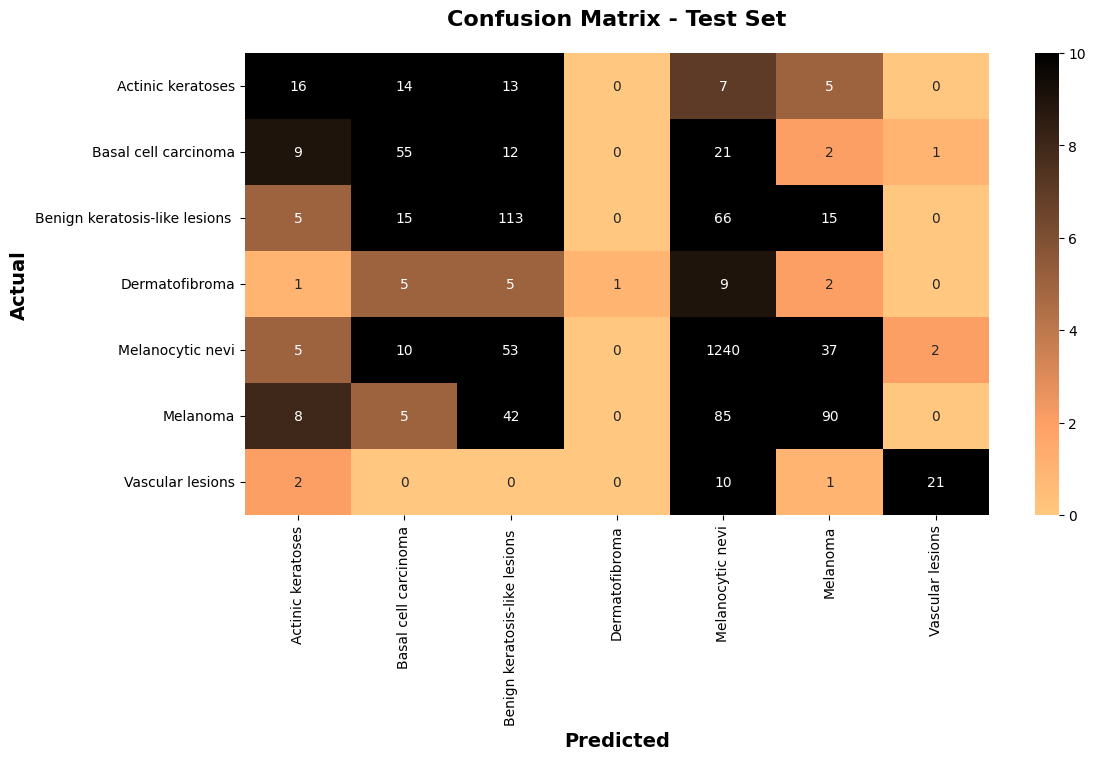

In [20]:
predictions = np.array(list(map(lambda x: np.argmax(x), predictions)))
print(predictions)
categories = ['Actinic keratoses',
              'Basal cell carcinoma',
              'Benign keratosis-like lesions ', 
              'Dermatofibroma', 
              'Melanocytic nevi', 
              'Melanoma',
              'Vascular lesions']

CMatrix = pd.DataFrame(confusion_matrix(y_test_o, predictions), columns=categories, index =categories)
plt.figure(figsize=(12, 6)) 
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 10,cmap = 'copper_r') 
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold') 
ax.set_xticklabels(ax.get_xticklabels(),rotation =90); 
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
plt.show()

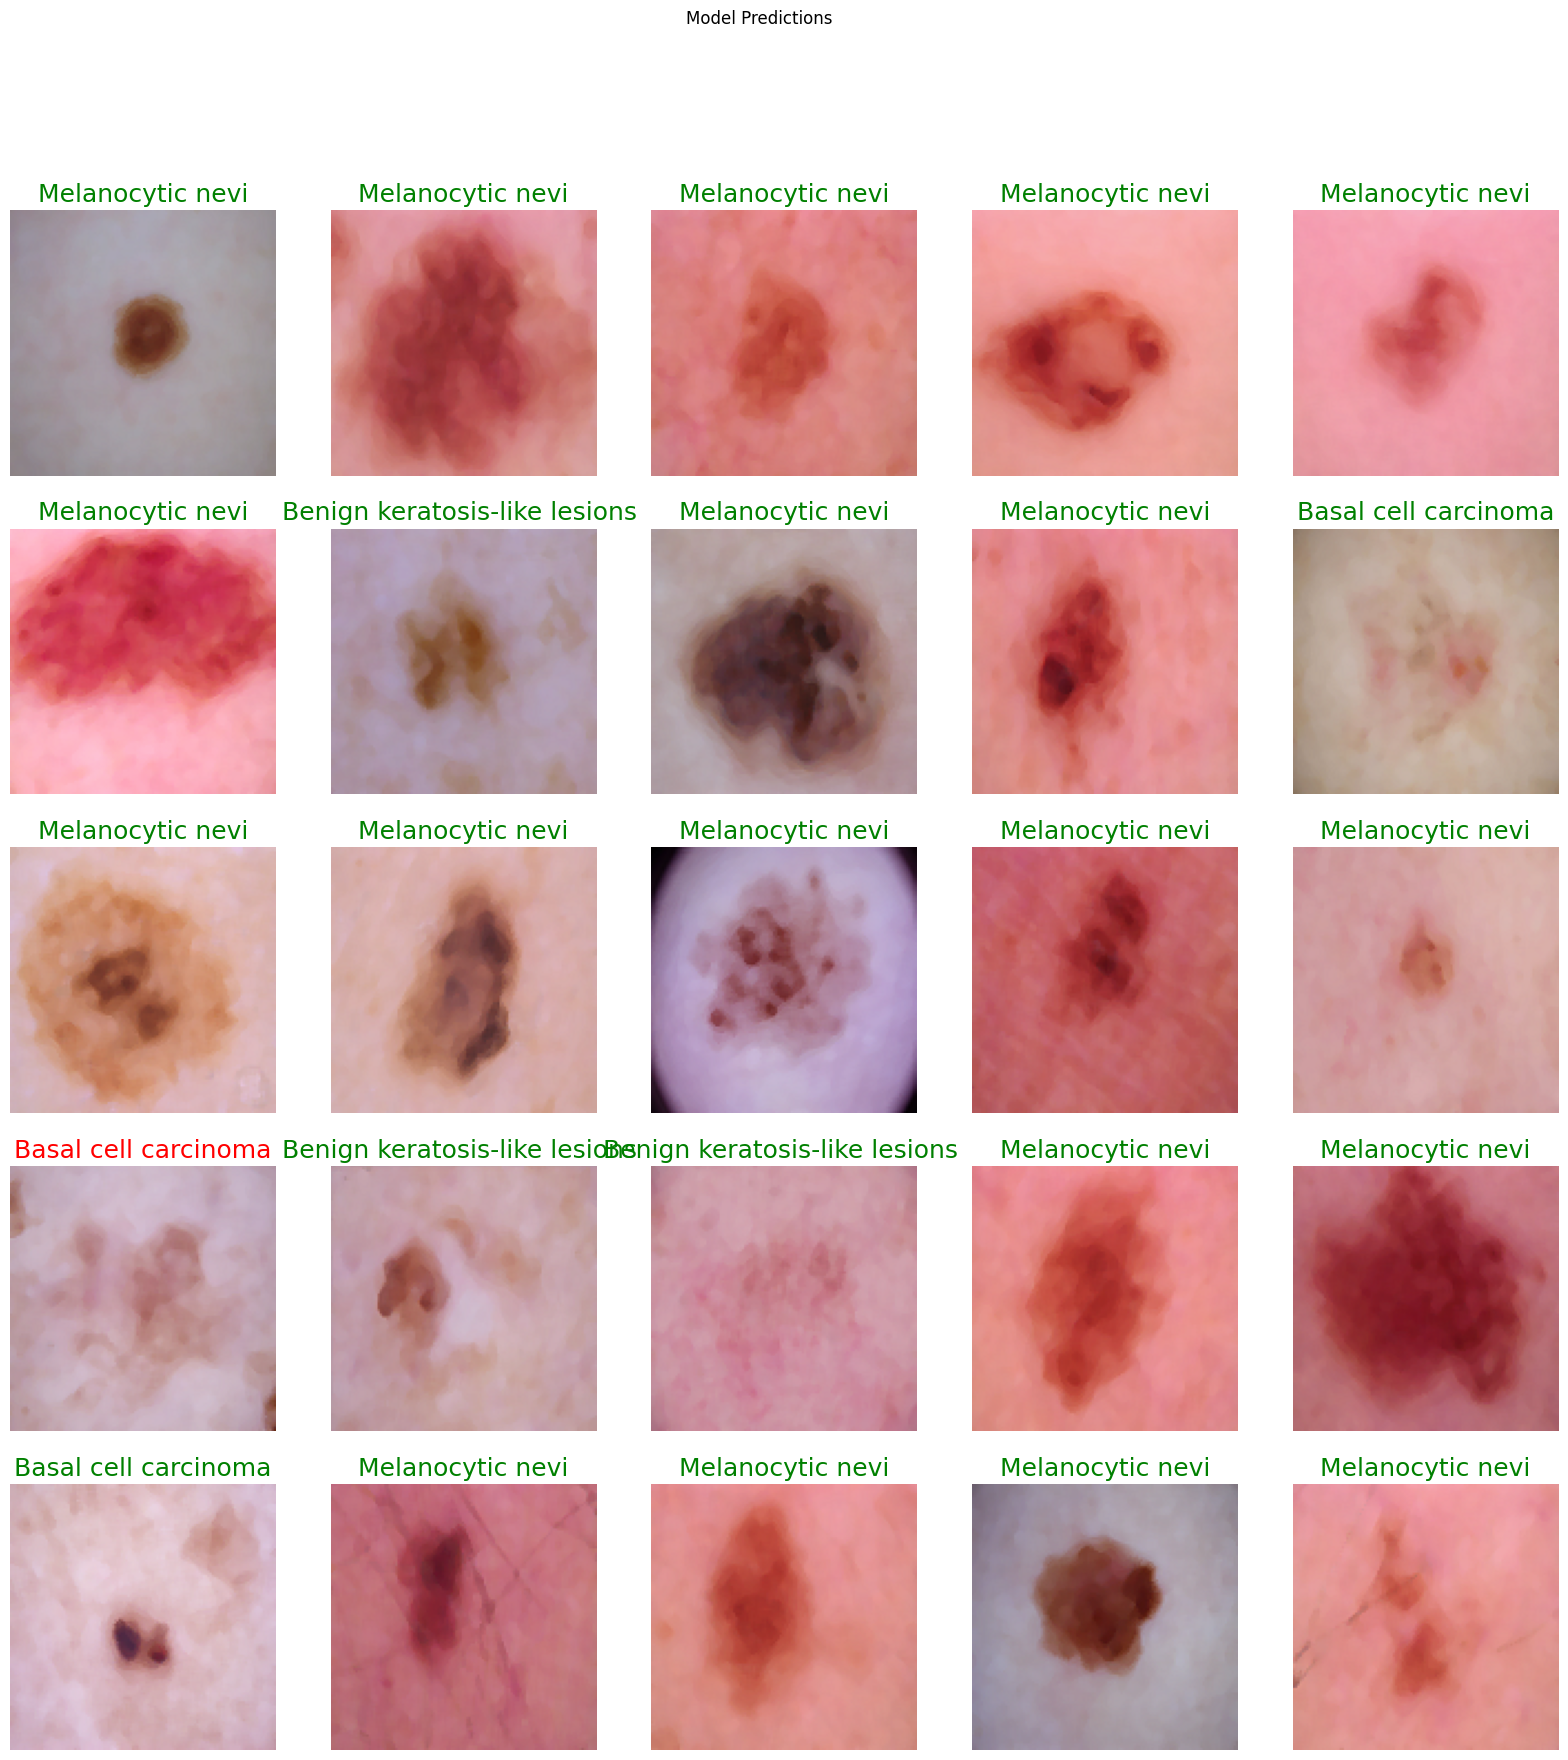

In [21]:
import pandas 
import random
import cv2 as cv
class_ids = {0:'Actinic keratoses',
              1:'Basal cell carcinoma',
              2:'Benign keratosis-like lesions ', 
              3:'Dermatofibroma', 
              4:'Melanocytic nevi', 
              5:'Melanoma',
              6:'Vascular lesions'}

y_test_o = pd.DataFrame(y_test_o)
y_test_o['predictions']=predictions

fig=plt.figure(figsize=(20,20))
for i in range (1,26):
    x=random.choice(list(x_test_o.index.values))
    fig.add_subplot(5,5,i)
    plt.imshow(x_test_o['image'][x],cmap="gray")
    if y_test_o['predictions'][x] == skin_df['cell_type_idx'][x]:
        title_color = "green"
    else :
        title_color="red"
    plt.title(class_ids[y_test_o['predictions'][x]],fontdict={'fontsize':18},color=title_color)
    plt.axis('off')
plt.suptitle("Model Predictions")  
plt.show()